In [ ]:
# =========================================================
# Imports
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, gaussian_kde

# =========================================================
# ①  生成 (x, y) 数据
# =========================================================
def generate_lrc_data(N, mu, r,
                      tau=0.75,
                      dist="normal",
                      df=None,                  # 仅 dist="t" 时必填
                      seed=None):
    """
    Parameters
    ----------
    dist : 'normal' | 't'
    df   : 自由度，仅在 dist='t' 时使用
    """
    if not 0 < r < 1:
        raise ValueError("r must be in (0,1)")
    if not 0 < tau < 1:
        raise ValueError("tau must be in (0,1)")
    if dist not in ("normal", "t"):
        raise ValueError("dist must be 'normal' or 't'")

    rng = np.random.default_rng(seed)

    if dist == "normal":
        x = rng.normal(mu, 1.0, N)
        theta = mu + norm.ppf(tau)
    else:  # t-distribution
        if df is None or df <= 0:
            raise ValueError("please specify positive df for t-distribution")
        x = rng.standard_t(df, N) + mu
        theta = mu + t.ppf(tau, df)

    # —— 本地随机化响应 y ——
    honest       = rng.random(N) < r
    random_bits  = rng.random(N) < 0.5
    truthful_bits= (x < theta)
    y = np.where(honest, truthful_bits, random_bits).astype(int)

    return x, y, theta

# =========================================================
# ②  单幅垂直镜像图
# =========================================================
def _plot_vertical(ax, x, y, theta, mu, r, tau,
                   dist="normal", df=None,
                   bins=30,
                   color_up="#6baed6", color_down="#fb6a4a"):
    N = len(x)

    # —— 直方图统计 ——
    edges   = np.histogram_bin_edges(x, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    width   = np.diff(edges)
    cnt_up,  _ = np.histogram(x, bins=edges)
    cnt_down, _= np.histogram(x, bins=edges, weights=y)
    max_h   = max(cnt_up.max(), cnt_down.max()) * 1.02

    # —— KDE ——
    grid  = np.linspace(-4, 4, 400)
    kde_u = gaussian_kde(x, bw_method='scott').evaluate(grid)  * N * width[0]
    kde_d = gaussian_kde(x, bw_method='scott', weights=y).evaluate(grid) * y.sum() * width[0]

    # —— 绘制直方图＋轮廓 ——
    ax.bar(centers,  cnt_up,  width=width,
           color=color_up, alpha=0.35, edgecolor="none")
    ax.plot(grid,   kde_u,  color=color_up,  lw=1.8, zorder=5)
    ax.bar(centers, -cnt_down, width=width,
           facecolor="none", edgecolor=color_down,
           hatch='//', linewidth=0)
    ax.plot(grid,  -kde_d,  color=color_down, lw=1.8, zorder=5)

    # —— 中轴、θ 线 ——
    ax.axhline(0,            color="black",  lw=1.2, zorder=4)
    ax.axvline(theta,        color="#2ca02c", ls="--", lw=1.8, zorder=6)

    # —— 轴设定 ——
    ax.set_xlim(-4, 4)
    ax.set_ylim(-max_h, max_h)
    ax.set_xticks([]); ax.set_yticks([])

    # 黑色边框
    for s in ax.spines.values():
        s.set_visible(True); s.set_linewidth(1.0)

    # —— 注释 ——  
    if dist == "normal":
        label_up = rf"$\mathcal{{N}}({mu},\,1)$"
    else:  # t
        label_up = rf"$t_{{{df}}}({mu},\,1)$"
    ax.text(-3.8,  0.90*max_h, label_up,  ha="left", va="top",    fontsize=15)
    ax.text(-3.8, -0.90*max_h, rf"$r={r}$", ha="left", va="bottom", fontsize=15)
    ax.annotate(rf"$\tau={tau}$",
                xy=(theta, 0), xytext=(theta+0.3, 0.15*max_h),
                arrowprops=dict(arrowstyle="->", color="#2ca02c", lw=1.5),
                ha="left", va="center", fontsize=15, color='black')

# =========================================================
# ③  1×2 子图比较
# =========================================================
def compare_two_scenes(scenes, N=50000, tau=0.75,
                       bins=30, seed=0, figsize=(9, 5)):
    """
    scenes: list of dict, 每个 dict 至少含 {'mu':.., 'r':..}
            可选键 'dist' ('normal'|'t') 与 'df' (当 dist='t')
    """
    plt.rcParams.update({"font.size": 12})
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    if len(scenes) != 2:
        raise ValueError("provide exactly two scenes")

    for idx, (ax, sc) in enumerate(zip(axes, scenes), start=1):
        mu  = sc["mu"];  r = sc["r"]
        dist= sc.get("dist", "normal")
        df  = sc.get("df", None)
        x, y, theta = generate_lrc_data(N, mu, r, tau,
                                        dist=dist, df=df, seed=seed)

        _plot_vertical(ax, x, y, theta,
                       mu=mu, r=r, tau=tau,
                       dist=dist, df=df,
                       bins=bins)

        # 圈号 1 / 2
        ax.text(0.94, 0.94, str(idx),
                transform=ax.transAxes,
                ha="right", va="top",
                bbox=dict(boxstyle="circle",
                          facecolor="white",
                          edgecolor="black",
                          linewidth=1.3),
                fontsize=12, fontweight="bold")

    fig.tight_layout()
    return fig

# --------------------------- Demo ---------------------------
if __name__ == "__main__":
    SCENES = [
        {"mu": 0.0, "r": 0.9, "dist": "normal"},
        {"mu": 1.0, "r": 0.5, "dist": "t", "df": 3}
    ]
    fig = compare_two_scenes(SCENES, N=20000, tau=0.75,
                             bins=40, seed=42,
                             figsize=(10, 5))
    plt.show()


SCENES = [
    {"mu": 0, "r": 0.2, "dist": "normal"},   # 图① 正态
    {"mu": 0, "r": 0.9, "dist": "t", "df": 5}    # 图② 科西
]

fig = compare_two_scenes(SCENES, N=50000, tau=0.5, bins=100,
                         figsize=(6, 4), seed=42)
plt.savefig('case3.pdf',dpi=250)
plt.show()          # 或 fig.savefig("two_panels.pdf", dpi=300)

In [12]:
K = 50
# t = 10**5
t = 10**5 * 0.98
Kt = K*t

In [13]:
np.log(np.log(2 * Kt))

np.float64(2.7786883903600015)

In [11]:
np.log(np.log(2 * Kt))

np.float64(2.779942594303269)

In [ ]:
# =========================================================
# Imports
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, gaussian_kde

# =========================================================
# ①  生成 (x, y) 数据
# =========================================================
def generate_lrc_data(N, mu, r,
                      tau=0.75,
                      dist="normal",
                      df=None,                  # 仅 dist='t' 时必填
                      seed=None):
    """
    Parameters
    ----------
    dist : 'normal' | 't'
    df   : 自由度，仅在 dist='t' 时使用
    """
    if not 0 < r < 1:
        raise ValueError("r must be in (0,1)")
    if not 0 < tau < 1:
        raise ValueError("tau must be in (0,1)")
    if dist not in ("normal", "t"):
        raise ValueError("dist must be 'normal' or 't'")

    rng = np.random.default_rng(seed)

    if dist == "normal":
        x = rng.normal(mu, 1.0, N)
        theta = mu + norm.ppf(tau)
    else:  # t-distribution
        if df is None or df <= 0:
            raise ValueError("please specify positive df for t-distribution")
        x = rng.standard_t(df, N) + mu
        theta = mu + t.ppf(tau, df)

    # —— 本地随机化响应 y ——
    honest        = rng.random(N) < r
    random_bits   = rng.random(N) < 0.5
    truthful_bits = (x < theta)
    y = np.where(honest, truthful_bits, random_bits).astype(int)

    return x, y, theta

# =========================================================
# ②  单幅图（蓝橙同向叠放，不翻转）
# =========================================================
def _plot_vertical(ax, x, y, theta, mu, r, tau,
                   dist="normal", df=None,
                   bins=30,
                   color_up="#6baed6", color_down="#fb6a4a"):
    N = len(x)

    # —— 直方图统计 ——
    edges   = np.histogram_bin_edges(x, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    width   = np.diff(edges)
    cnt_up,  _ = np.histogram(x, bins=edges)
    cnt_down, _= np.histogram(x, bins=edges, weights=y)
    max_h   = max(cnt_up.max(), cnt_down.max()) * 1.05

    # —— KDE ——
    grid  = np.linspace(-4, 4, 400)
    kde_u = gaussian_kde(x, bw_method='scott').evaluate(grid)  * N * width[0]
    kde_d = gaussian_kde(x, bw_method='scott', weights=y).evaluate(grid) * y.sum() * width[0]

    # —— 绘制直方图＋轮廓 ——
    ax.bar(centers, cnt_up,   width=width,
           color=color_up, alpha=0.35, edgecolor="none")
    ax.plot(grid,   kde_u,    color=color_up,  lw=1.8, zorder=5)

    ax.bar(centers, cnt_down, width=width,
           facecolor="none", edgecolor=color_down,
           hatch='//', linewidth=0)
    ax.plot(grid,   kde_d,    color=color_down, lw=1.8, zorder=5)

    # —— 中轴、θ 线 ——
    ax.axhline(0,            color="black",  lw=1.2, zorder=4)
    ax.axvline(theta,        color="#2ca02c", ls="--", lw=1.8, zorder=6)

    # —— 轴设定 ——
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, max_h)
    ax.set_xticks([]); ax.set_yticks([])

    # 黑色边框
    for s in ax.spines.values():
        s.set_visible(True); s.set_linewidth(1.0)

    # —— 注释 ——  
    if dist == "normal":
        label_up = rf"$\mathcal{{N}}({mu},\,1)$"
    else:  # t
        label_up = rf"$t_{{{df}}}({mu},\,1)$"

    # 统一用轴坐标 (0–1) 放在左上角，左右子图位置一致
    ax.text(0.03, 0.97,
            label_up + "\n" + rf"$r={r}$",
            transform=ax.transAxes,
            ha="left", va="top", fontsize=15)

    # θ 的注释（仍用数据坐标）
    ax.annotate(rf"$\tau={tau}$",
                xy=(theta, 0), xytext=(theta+0.3, 0.12*max_h),
                arrowprops=dict(arrowstyle="->", color="#2ca02c", lw=1.5),
                ha="left", va="center", fontsize=15, color='black')

# =========================================================
# ③  1×2 子图比较
# =========================================================
def compare_two_scenes(scenes, N=50000, tau=0.75,
                       bins=30, seed=0, figsize=(9, 5)):
    """
    scenes: list of dict, 每个 dict 至少含 {'mu':.., 'r':..}
            可选键 'dist' ('normal'|'t') 与 'df' (当 dist='t')
    """
    plt.rcParams.update({"font.size": 12})
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    if len(scenes) != 2:
        raise ValueError("provide exactly two scenes")

    for idx, (ax, sc) in enumerate(zip(axes, scenes), start=1):
        mu  = sc["mu"];  r = sc["r"]
        dist= sc.get("dist", "normal")
        df  = sc.get("df", None)
        x, y, theta = generate_lrc_data(N, mu, r, tau,
                                        dist=dist, df=df, seed=seed)

        _plot_vertical(ax, x, y, theta,
                       mu=mu, r=r, tau=tau,
                       dist=dist, df=df,
                       bins=bins)

        # 圈号 1 / 2
        ax.text(0.94, 0.94, str(idx),
                transform=ax.transAxes,
                ha="right", va="top",
                bbox=dict(boxstyle="circle",
                          facecolor="white",
                          edgecolor="black",
                          linewidth=1.3),
                fontsize=12, fontweight="bold")

    fig.tight_layout()
    return fig

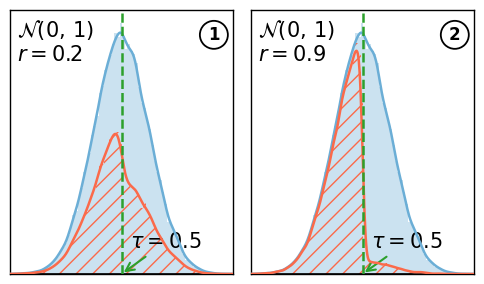

In [13]:
# --------------------------- Demo ---------------------------
if __name__ == "__main__":
    SCENES = [
        {"mu": 0, "r": 0.2, "dist": "normal"},      # 图① 正态
        {"mu": 0, "r": 0.9, "dist": "normal"}   # 图② t 分布
    ]
    fig = compare_two_scenes(SCENES, N=50000, tau=0.5,
                             bins=100, figsize=(5, 3), seed=42)
    plt.savefig('case1.pdf', dpi=250)
    plt.show()      # 或 fig.savefig("two_panels.pdf", dpi=300)

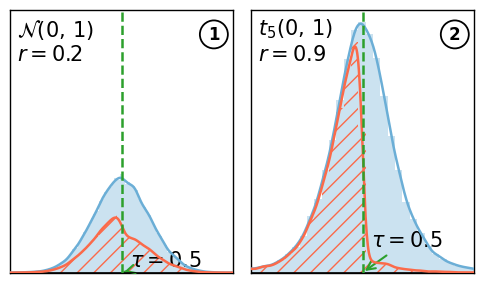

In [ ]:
# --------------------------- Demo ---------------------------
if __name__ == "__main__":
    SCENES = [
        {"mu": 0, "r": 0.2, "dist": "normal"},      # 图① 正态
        {"mu": 0, "r": 0.9, "dist": "t", "df": 5}   # 图② t 分布
    ]
    fig = compare_two_scenes(SCENES, N=50000, tau=0.5,
                             bins=100, figsize=(5, 3), seed=42)
    plt.savefig('case3.pdf', dpi=250)
    plt.show()      # 或 fig.savefig("two_panels.pdf", dpi=300)

In [22]:
# =========================================================
# Imports
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, gaussian_kde

# =========================================================
# ①  生成 (x, y) 数据
# =========================================================
def generate_lrc_data(N, mu, r,
                      tau=0.75,
                      dist="normal",
                      df=None,
                      seed=None):
    if not 0 < r < 1:
        raise ValueError("r must be in (0,1)")
    if not 0 < tau < 1:
        raise ValueError("tau must be in (0,1)")
    if dist not in ("normal", "t"):
        raise ValueError("dist must be 'normal' or 't'")

    rng = np.random.default_rng(seed)

    if dist == "normal":
        x      = rng.normal(mu, 1.0, N)
        theta  = mu + norm.ppf(tau)
    else:
        if df is None or df <= 0:
            raise ValueError("positive df must be specified for t-distribution")
        x      = rng.standard_t(df, N) + mu
        theta  = mu + t.ppf(tau, df)

    honest        = rng.random(N) < r
    random_bits   = rng.random(N) < 0.5
    truthful_bits = (x < theta)
    y = np.where(honest, truthful_bits, random_bits).astype(int)

    return x, y, theta

# =========================================================
# ②  单幅子图
# =========================================================
def _plot_vertical(ax, x, y, theta, mu, r, tau,
                   dist="normal", df=None,
                   bins=30,
                   y_max=None,                  # ←★ 新增：全局 y 轴上限
                   color_up="#6baed6", color_down="#fb6a4a"):
    N = len(x)

    # —— 直方图（频率） ——
    edges   = np.histogram_bin_edges(x, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    width   = np.diff(edges)

    cnt_up,  _ = np.histogram(x, bins=edges)
    cnt_down, _= np.histogram(x, bins=edges, weights=y)
    cnt_up   = cnt_up   / N                          # ←★ 频率
    cnt_down = cnt_down / N                          # ←★ 频率

    # —— KDE 曲线（频率） ——
    grid  = np.linspace(-4, 4, 400)
    pdf_u = gaussian_kde(x, bw_method='scott').evaluate(grid)
    kde_u = pdf_u * width[0]                         # ←★ 频率

    prop1 = y.mean()                                # P(y=1)
    if prop1 > 0:
        pdf_d = gaussian_kde(x, bw_method='scott', weights=y).evaluate(grid)
        kde_d = pdf_d * width[0] * prop1            # ←★ 频率
    else:
        kde_d = np.zeros_like(grid)

    # —— 使用给定的 y_max 统一纵轴 ——
    if y_max is None:
        y_max = max(cnt_up.max(), kde_u.max()) * 1.05

    # —— 绘图 ——
    ax.bar(centers, cnt_up, width=width,
           color=color_up, alpha=0.35, edgecolor="none")
    ax.plot(grid,   kde_u,  color=color_up,  lw=1.8, zorder=5)

    ax.bar(centers, cnt_down, width=width,
           facecolor="none", edgecolor=color_down,
           hatch='//', linewidth=0)
    ax.plot(grid,   kde_d,  color=color_down, lw=1.8, zorder=5)

    ax.axhline(0,       color="black",  lw=1.2, zorder=4)
    ax.axvline(theta,   color="#2ca02c", ls="--", lw=1.8, zorder=6)

    ax.set_xlim(-4, 4)
    ax.set_ylim(0, y_max)                           # ←★ 统一纵轴
    ax.set_xticks([]); ax.set_yticks([])

    for s in ax.spines.values():
        s.set_visible(True); s.set_linewidth(1.0)

    # —— 注释 ——  
    label_up = (rf"$\mathcal{{N}}({mu},\,1)$" if dist == "normal"
                else rf"$t_{{{df}}}({mu},\,1)$")
    ax.text(0.03, 0.97,
            label_up + "\n" + rf"$r={r}$",
            transform=ax.transAxes,
            ha="left", va="top", fontsize=15)

    ax.annotate(rf"$\tau={tau}$",
                xy=(theta, 0), xytext=(theta+0.3, 0.12*y_max),
                arrowprops=dict(arrowstyle="->", color="#2ca02c", lw=1.5),
                ha="left", va="center", fontsize=15, color='black')

# =========================================================
# ③  1×2 子图比较
# =========================================================
def compare_two_scenes(scenes, N=50000, tau=0.75,
                       bins=30, seed=0, figsize=(9, 5)):
    plt.rcParams.update({"font.size": 12})
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    if len(scenes) != 2:
        raise ValueError("provide exactly two scenes")

    # —— 计算统一 y 轴上限 ——★
    width_ref = 8 / bins                     # 因为 x-lim 固定为 [-4,4]
    pdf0_t5   = t.pdf(0, df=5)               # t5(0,1) 在 0 处的 pdf
    y_max     = pdf0_t5 * width_ref * 3.37   # 再放大 10%

    for idx, (ax, sc) in enumerate(zip(axes, scenes), start=1):
        mu   = sc["mu"];  r = sc["r"]
        dist = sc.get("dist", "normal")
        df   = sc.get("df", None)
        x, y, theta = generate_lrc_data(N, mu, r, tau,
                                        dist=dist, df=df, seed=seed)

        _plot_vertical(ax, x, y, theta,
                       mu=mu, r=r, tau=tau,
                       dist=dist, df=df,
                       bins=bins,
                       y_max=y_max)          # ←★ 传入统一 y_max

        ax.text(0.94, 0.94, str(idx),
                transform=ax.transAxes,
                ha="right", va="top",
                bbox=dict(boxstyle="circle",
                          facecolor="white",
                          edgecolor="black",
                          linewidth=1.3),
                fontsize=12, fontweight="bold")

    fig.tight_layout()
    return fig

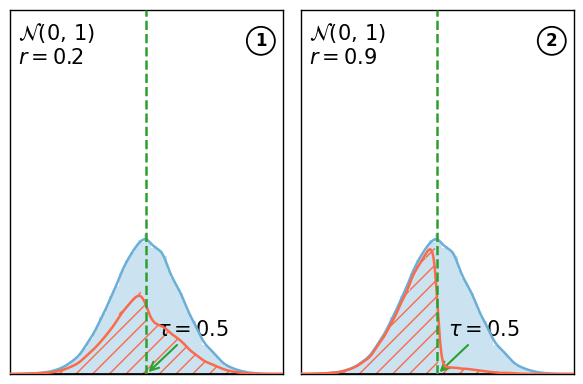

In [23]:
# --------------------------- Demo ---------------------------
if __name__ == "__main__":
    SCENES = [
        {"mu": 0, "r": 0.2, "dist": "normal"},      # 图① 正态
        {"mu": 0, "r": 0.9, "dist": "normal"}   # 图② t 分布
    ]
    fig = compare_two_scenes(SCENES, N=50000, tau=0.5,
                             bins=100, figsize=(6, 4), seed=42)
    plt.savefig('case1.pdf', dpi=250)
    plt.show()

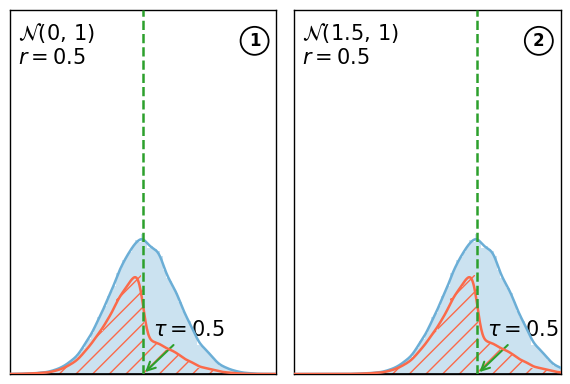

In [25]:
# --------------------------- Demo ---------------------------
if __name__ == "__main__":
    SCENES = [
        {"mu": 0, "r": 0.5, "dist": "normal"},      # 图① 正态
        {"mu": 1.5, "r": 0.5, "dist": "normal"}   # 图② t 分布
    ]
    fig = compare_two_scenes(SCENES, N=50000, tau=0.5,
                             bins=100, figsize=(6, 4), seed=42)
    plt.savefig('case2.pdf', dpi=250)
    plt.show()

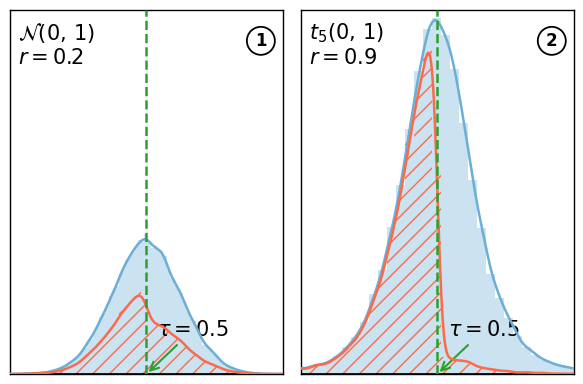

In [24]:
# --------------------------- Demo ---------------------------
if __name__ == "__main__":
    SCENES = [
        {"mu": 0, "r": 0.2, "dist": "normal"},      # 图① 正态
        {"mu": 0, "r": 0.9, "dist": "t", "df": 5}   # 图② t 分布
    ]
    fig = compare_two_scenes(SCENES, N=50000, tau=0.5,
                             bins=100, figsize=(6, 4), seed=42)
    plt.savefig('case3.pdf', dpi=250)
    plt.show()